# setup

In [1]:
cd /data/dfried/projects/alfred/alfred

/data/dfried/projects/alfred/alfred


In [2]:
!export ALFRED_ROOT="/data/dfried/projects/alfred/alfred"

In [3]:
import pandas

In [4]:
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

In [6]:
from analysis import *

In [7]:
with open(SPLITS) as f:
    splits = json.load(f)

In [8]:
train = splits['train']
valid_seen = splits['valid_seen']
valid_unseen = splits['valid_unseen']
tests_unseen = splits['tests_unseen']
tests_seen = splits['tests_seen']

In [9]:
def extract_pddl_actions(task_data):
    high_pddl = task_data['plan']['high_pddl']
    return [
        action['discrete_action'] for action in high_pddl
    ]

In [10]:
import tqdm.notebook

In [11]:
from collections import namedtuple
TaskInfo = namedtuple("TaskInfo", ["path", "high_level_task", "high_level_params", "scene"])

In [12]:
def parse_task_info(task_path):
    tokens = task_path.split('/')[0].split('-')
    return TaskInfo(
        path=task_path,
        high_level_task=tokens[0],
        high_level_params=tuple(tokens[1:-1]),
        scene=int(tokens[-1])
    )

In [13]:
def get_high_level_actions(tasks):
    for task in tqdm.notebook.tqdm(tasks):
        data = load_task_json(task)
        yield(extract_pddl_actions(data))

In [14]:
def build_data_frame(tasks):
    all_actions = []
    all_actions_flat = []
    for task in tqdm.notebook.tqdm(tasks):
        data = load_task_json(task)
        task_info = parse_task_info(task['task'])._asdict()
        task_info['repeat_idx'] = task['repeat_idx']

        actions = extract_pddl_actions(data)
        all_actions.append(actions)
        
        task_info['high_level_task_and_params'] = (task_info['high_level_task'],) + task_info['high_level_params']

        task_info['num_high_level_actions'] = len(actions)
        task_info['num_low_level_actions'] = len(data['plan']['low_actions'])

        for action in actions:
            this_data = {k: tuple(v) if isinstance(v, list) else v for k, v in {
                **action,
                **task_info
            }.items()}
            this_data['action_and_args'] = (this_data['action'],) + this_data['args']
            all_actions_flat.append(this_data)
    return pandas.DataFrame(all_actions_flat)

In [15]:
data = load_task_json(train[0])
# data['ann']['instr']

In [16]:
def get_segmented_instructions(tasks):
    for task in tqdm.notebook.tqdm(tasks):
        data = load_task_json(task)
        plan = data['plan']['high_pddl']
        seg_instr = data['ann']['instr']
        if len(seg_instr) != len(plan):
            continue
        yield list(zip([ac['discrete_action']['action'] for ac in plan], seg_instr))

In [17]:
import numpy as np

In [18]:
# data['plan']['high_pddl']

In [19]:
from collections import Counter, defaultdict

In [20]:
def get_segment_stats(tasks):
    num_segments = []
    segment_lengths = []
    segment_lengths_by_label = defaultdict(list)
    total_lengths = []
    for labelled_seg_instr in get_segmented_instructions(tasks):
        num_segments.append(len(labelled_seg_instr))
        for label, segment in labelled_seg_instr:
            segment_lengths.append(len(segment))
            segment_lengths_by_label[label].append(len(segment))
        total_lengths.append(sum(len(s) for l, s in labelled_seg_instr))
    print('max number of segments: {}'.format(max(num_segments)))
    print('avg number of segments: {}'.format(np.mean(num_segments)))
    print('std dev number of segments: {}'.format(np.std(num_segments)))
    print('max segment length: {}'.format(max(segment_lengths)))
    print('avg segment length: {}'.format(np.mean(num_segments)))
    print('avg segment length: {}'.format(np.mean(segment_lengths)))
    print('avg total lengths: {}'.format(np.mean(total_lengths)))
    print('std dev total lengths: {}'.format(np.std(total_lengths)))
    return segment_lengths_by_label

In [21]:
train_len_by_label = get_segment_stats(train)


max number of segments: 20
avg number of segments: 7.714122464527188
std dev number of segments: 2.489341064458155
max segment length: 62
avg segment length: 7.714122464527188
avg segment length: 10.834185122089721
avg total lengths: 83.57623083515855
std dev total lengths: 37.153109045965415


In [22]:
# train_len_by_label

In [23]:
import matplotlib.pyplot as plt

In [24]:
%matplotlib inline

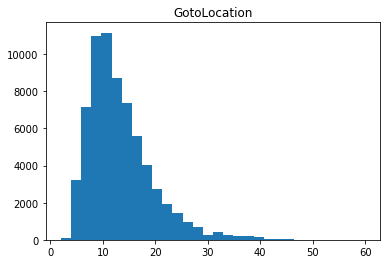

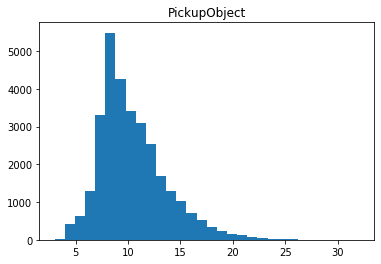

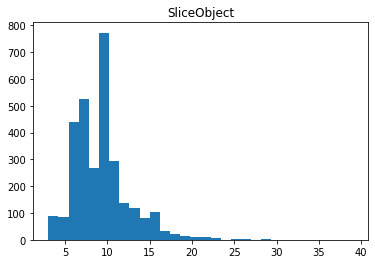

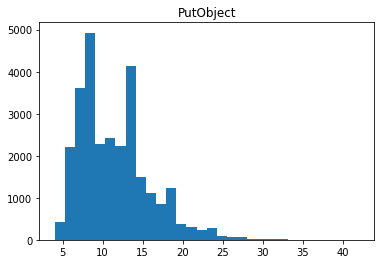

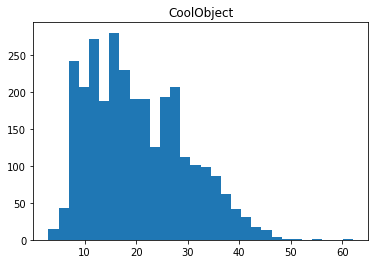

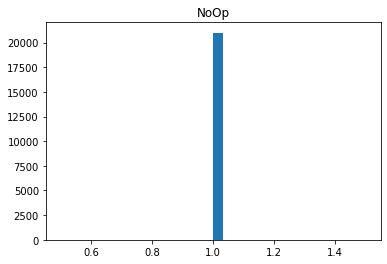

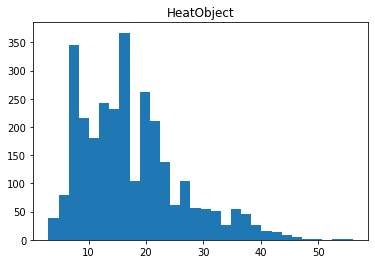

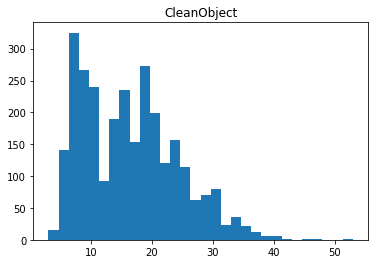

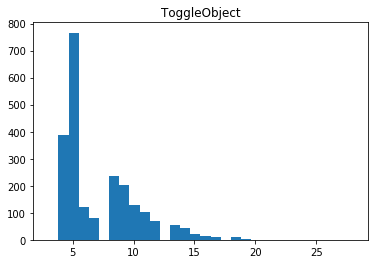

In [25]:
for label, counts in train_len_by_label.items():
    plt.hist(counts, density=False, bins=30,)
    plt.title(label)
    plt.show()

In [26]:
plt.plot

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

In [27]:
_ = get_segment_stats(valid_seen)
_ = get_segment_stats(valid_unseen)


max number of segments: 17
avg number of segments: 7.7926829268292686
std dev number of segments: 2.7258375525477003
max segment length: 54
avg segment length: 7.7926829268292686
avg segment length: 10.696870109546166
avg total lengths: 83.35731707317073
std dev total lengths: 41.12047003885702



max number of segments: 15
avg number of segments: 7.21840490797546
std dev number of segments: 2.283878932245277
max segment length: 49
avg segment length: 7.21840490797546
avg segment length: 10.97467278599354
avg total lengths: 79.21963190184049
std dev total lengths: 36.082347635754644


In [28]:
train_df = build_data_frame(train)
valid_seen_df = build_data_frame(valid_seen)
valid_unseen_df = build_data_frame(valid_unseen)

In [29]:
train_df

,action,args,path,high_level_task,high_level_params,scene,repeat_idx,high_level_task_and_params,num_high_level_actions,num_low_level_actions,action_and_args
0,GotoLocation,"(diningtable,)",pick_cool_then_place_in_recep-LettuceSliced-No...,pick_cool_then_place_in_recep,"(LettuceSliced, None, DiningTable)",17,0,"(pick_cool_then_place_in_recep, LettuceSliced,...",12,67,"(GotoLocation, diningtable)"
1,PickupObject,"(knife,)",pick_cool_then_place_in_recep-LettuceSliced-No...,pick_cool_then_place_in_recep,"(LettuceSliced, None, DiningTable)",17,0,"(pick_cool_then_place_in_recep, LettuceSliced,...",12,67,"(PickupObject, knife)"
2,SliceObject,"(lettuce,)",pick_cool_then_place_in_recep-LettuceSliced-No...,pick_cool_then_place_in_recep,"(LettuceSliced, None, DiningTable)",17,0,"(pick_cool_then_place_in_recep, LettuceSliced,...",12,67,"(SliceObject, lettuce)"
3,GotoLocation,"(fridge,)",pick_cool_then_place_in_recep-LettuceSliced-No...,pick_cool_then_place_in_recep,"(LettuceSliced, None, DiningTable)",17,0,"(pick_cool_then_place_in_recep, LettuceSliced,...",12,67,"(GotoLocation, fridge)"
4,PutObject,"(knife, fridge)",pick_cool_then_place_in_recep-LettuceSliced-No...,pick_cool_then_place_in_recep,"(LettuceSliced, None, DiningTable)",17,0,"(pick_cool_then_place_in_recep, LettuceSliced,...",12,67,"(PutObject, knife, fridge)"
...,...,...,...,...,...,...,...,...,...,...,...
162301,GotoLocation,"(sinkbasin,)",pick_clean_then_place_in_recep-Cloth-None-Draw...,pick_clean_then_place_in_recep,"(Cloth, None, Drawer)",411,2,"(pick_clean_then_place_in_recep, Cloth, None, ...",7,27,"(GotoLocation, sinkbasin)"
162302,CleanObject,"(cloth,)",pick_clean_then_place_in_recep-Cloth-None-Draw...,pick_clean_then_place_in_recep,"(Cloth, None, Drawer)",411,2,"(pick_clean_then_place_in_recep, Cloth, None, ...",7,27,"(CleanObject, cloth)"
162303,GotoLocation,"(drawer,)",pick_clean_then_place_in_recep-Cloth-None-Draw...,pick_clean_then_place_in_recep,"(Cloth, None, Drawer)",411,2,"(pick_clean_then_place_in_recep, Cloth, None, ...",7,27,"(GotoLocation, drawer)"
162304,PutObject,"(cloth, drawer)",pick_clean_then_place_in_recep-Cloth-None-Draw...,pick_clean_then_place_in_recep,"(Cloth, None, Drawer)",411,2,"(pick_clean_then_place_in_recep, Cloth, None, ...",7,27,"(PutObject, cloth, drawer)"


In [30]:
def display_jaccard(set1, set2):
    num = len(set1 & set2)
    denom = len(set1 | set2)
    print("\tin 1st       : {}".format(len(set1)))
    print("\tin 1st \\ 2nd : {}".format(len(set1 - set2)))
    print("\tin 2nd       : {}".format(len(set2)))
    print("\tin 2nd \\ 1st : {}".format(len(set2 - set1)))
    print("\tjaccard\t{} / {} = {:.2f}".format(num, denom, float(num) / denom))

In [31]:
display_jaccard(set(train_df['high_level_task_and_params']), set(valid_seen_df['high_level_task_and_params']))

	in 1st       : 933
	in 1st \ 2nd : 732
	in 2nd       : 201
	in 2nd \ 1st : 0
	jaccard	201 / 933 = 0.22


# held-out tasks

In [32]:
# train

In [33]:
def pick_two(task):
    return task['task'].split('-')[0] == 'pick_two_obj_and_place'

In [34]:
def pick_place_movable(task):
    return task['task'].split('-')[0] == 'pick_and_place_with_movable_recep'

In [35]:
len([t for t in train if pick_two(t)])

3554

In [36]:
len([t for t in train if pick_place_movable(t)])

3244

In [37]:
train_pick_2 = [d for d in train if not pick_two(d)]
valid_seen_pick_2 = [d for d in valid_seen if pick_two(d)]
valid_unseen_pick_2 = [d for d in valid_unseen if pick_two(d)]
tests_seen_pick_2 = []
tests_unseen_pick_2 = []

print("pick 2")
print("train: {} / {}".format(len(train_pick_2), len(train)))
print("valid_seen: {} / {}".format(len(valid_seen_pick_2), len(valid_seen)))
print("valid_unseen: {} / {}".format(len(valid_unseen_pick_2), len(valid_unseen)))
print("tests_seen: {} / {}".format(len(tests_seen_pick_2), len(tests_seen)))
print("tests_unseen: {} / {}".format(len(tests_unseen_pick_2), len(tests_unseen)))

pick 2
train: 17469 / 21023
valid_seen: 124 / 820
valid_unseen: 81 / 821
tests_seen: 0 / 1533
tests_unseen: 0 / 1529


In [38]:
# with open('data/splits/pick_2.json', 'w') as f:
#     json.dump({
#         'train': train_pick_2,
#         'valid_seen': valid_seen_pick_2,
#         'valid_unseen': valid_unseen_pick_2,
#         'tests_seen': tests_seen_pick_2,
#         'tests_unseen': tests_unseen_pick_2,
#     }, f)

In [39]:
train_movable = [d for d in train if not pick_place_movable(d)]
valid_seen_movable = [d for d in valid_seen if pick_place_movable(d)]
valid_unseen_movable = [d for d in valid_unseen if pick_place_movable(d)]
tests_seen_movable = []
tests_unseen_movable = []

print("movable")
print("train: {} / {}".format(len(train_movable), len(train)))
print("valid_seen: {} / {}".format(len(valid_seen_movable), len(valid_seen)))
print("valid_unseen: {} / {}".format(len(valid_unseen_movable), len(valid_unseen)))

movable
train: 17779 / 21023
valid_seen: 115 / 820
valid_unseen: 109 / 821


In [40]:
# with open('data/splits/movable.json', 'w') as f:
#     json.dump({
#         'train': train_movable,
#         'valid_seen': valid_seen_movable,
#         'valid_unseen': valid_unseen_movable,
#         'tests_seen': tests_seen_movable,
#         'tests_unseen': tests_unseen_movable,
#     }, f)

In [41]:
_ = get_segment_stats(train_pick_2)


max number of segments: 15
avg number of segments: 7.428473295552121
std dev number of segments: 2.5872808901274755
max segment length: 62
avg segment length: 7.428473295552121
avg segment length: 10.79227544541027
avg total lengths: 80.17012994447306
std dev total lengths: 37.37539059579396


In [42]:
_= get_segment_stats(valid_seen_pick_2)


max number of segments: 17
avg number of segments: 9.387096774193548
std dev number of segments: 1.7166625413742027
max segment length: 48
avg segment length: 9.387096774193548
avg segment length: 11.584192439862543
avg total lengths: 108.74193548387096
std dev total lengths: 41.174074008378746


In [43]:
train_pick_2_df = build_data_frame(train_pick_2)

In [44]:

valid_seen_pick_2_df = build_data_frame(valid_seen_pick_2)

In [45]:
train_pick_2_actions_counter = Counter(
    tuple(d['action'] for d in acs)
    for acs in get_high_level_actions(train_pick_2)
)

In [46]:
valid_seen_pick_2_actions_counter = Counter(
    tuple(d['action'] for d in acs)
    for acs in get_high_level_actions(valid_seen_pick_2)
)

In [47]:
train_pick_2_actions_counter

Counter({('GotoLocation',
          'PickupObject',
          'SliceObject',
          'GotoLocation',
          'PutObject',
          'GotoLocation',
          'PickupObject',
          'GotoLocation',
          'CoolObject',
          'GotoLocation',
          'PutObject',
          'NoOp'): 73,
         ('GotoLocation',
          'PickupObject',
          'GotoLocation',
          'HeatObject',
          'GotoLocation',
          'PutObject',
          'NoOp'): 1764,
         ('GotoLocation',
          'PickupObject',
          'GotoLocation',
          'CleanObject',
          'GotoLocation',
          'PutObject',
          'NoOp'): 2483,
         ('GotoLocation',
          'PickupObject',
          'GotoLocation',
          'PutObject',
          'NoOp'): 3181,
         ('GotoLocation',
          'PickupObject',
          'GotoLocation',
          'SliceObject',
          'GotoLocation',
          'PutObject',
          'GotoLocation',
          'PickupObject',
          'GotoLo

In [48]:
valid_seen_pick_2_actions_counter

Counter({('GotoLocation',
          'PickupObject',
          'GotoLocation',
          'PutObject',
          'GotoLocation',
          'PickupObject',
          'GotoLocation',
          'PutObject',
          'NoOp'): 118,
         ('GotoLocation',
          'PickupObject',
          'GotoLocation',
          'PutObject',
          'GotoLocation',
          'PickupObject',
          'GotoLocation',
          'SliceObject',
          'CoolObject',
          'PutObject',
          'GotoLocation',
          'PickupObject',
          'GotoLocation',
          'PutObject',
          'PickupObject',
          'SliceObject',
          'NoOp'): 6})

In [49]:
# Pick-2 high-level action sequences that aren't in train
Counter({
    k: v for (k, v) in valid_seen_pick_2_actions_counter.items() 
    if k not in train_pick_2_actions_counter.keys()
})

Counter({('GotoLocation',
          'PickupObject',
          'GotoLocation',
          'PutObject',
          'GotoLocation',
          'PickupObject',
          'GotoLocation',
          'SliceObject',
          'CoolObject',
          'PutObject',
          'GotoLocation',
          'PickupObject',
          'GotoLocation',
          'PutObject',
          'PickupObject',
          'SliceObject',
          'NoOp'): 6})

In [50]:
# for task in train_pick_2:
#     data = load_task_json(task)
#     actions = extract_pddl_actions(data)
#     acs = tuple(d['action'] for d in actions)
#     if acs in valid_seen_pick_2_actions_counter:
#         print(task)

In [51]:
# MOVABLE

In [52]:
_ = get_segment_stats(train_movable)


max number of segments: 20
avg number of segments: 7.527649510079964
std dev number of segments: 2.507247340582568
max segment length: 62
avg segment length: 7.527649510079964
avg segment length: 10.872071276818577
avg total lengths: 81.8411420204978
std dev total lengths: 37.52063280537181


In [53]:
_= get_segment_stats(valid_seen_movable)


max number of segments: 14
avg number of segments: 9.278260869565218
std dev number of segments: 2.531704447641537
max segment length: 43
avg segment length: 9.278260869565218
avg segment length: 10.66447985004686
avg total lengths: 98.94782608695652
std dev total lengths: 39.485791275665306


In [54]:
train_movable_actions_counter = Counter(
    tuple(d['action'] for d in acs)
    for acs in get_high_level_actions(train_movable)
)

In [55]:
valid_seen_movable_actions_counter = Counter(
    tuple(d['action'] for d in acs)
    for acs in get_high_level_actions(valid_seen_movable)
)

In [56]:
valid_seen_movable_actions_counter

Counter({('GotoLocation',
          'PickupObject',
          'GotoLocation',
          'PutObject',
          'PickupObject',
          'GotoLocation',
          'PutObject',
          'NoOp'): 49,
         ('GotoLocation',
          'PickupObject',
          'GotoLocation',
          'SliceObject',
          'PutObject',
          'PickupObject',
          'GotoLocation',
          'PutObject',
          'PickupObject',
          'GotoLocation',
          'PutObject',
          'NoOp'): 14,
         ('GotoLocation',
          'PickupObject',
          'PutObject',
          'PickupObject',
          'GotoLocation',
          'PutObject',
          'NoOp'): 12,
         ('GotoLocation',
          'PickupObject',
          'GotoLocation',
          'PutObject',
          'PickupObject',
          'PutObject',
          'GotoLocation',
          'PickupObject',
          'GotoLocation',
          'SliceObject',
          'NoOp'): 3,
         ('GotoLocation',
          'PickupObject',
  

In [57]:
# for task in train_movable:
#     data = load_task_json(task)
#     actions = extract_pddl_actions(data)
#     acs = tuple(d['action'] for d in actions)
#     if acs in valid_seen_movable_actions_counter:
#         print(task)

In [58]:
# Movable high-level action sequences that aren't in train
Counter({
    k: v for (k, v) in valid_seen_movable_actions_counter.items() 
    if k not in train_movable_actions_counter.keys()
})

Counter({('GotoLocation',
          'PickupObject',
          'GotoLocation',
          'PutObject',
          'PickupObject',
          'GotoLocation',
          'PutObject',
          'NoOp'): 49,
         ('GotoLocation',
          'PickupObject',
          'GotoLocation',
          'SliceObject',
          'PutObject',
          'PickupObject',
          'GotoLocation',
          'PutObject',
          'PickupObject',
          'GotoLocation',
          'PutObject',
          'NoOp'): 14,
         ('GotoLocation',
          'PickupObject',
          'PutObject',
          'PickupObject',
          'GotoLocation',
          'PutObject',
          'NoOp'): 12,
         ('GotoLocation',
          'PickupObject',
          'GotoLocation',
          'PutObject',
          'PickupObject',
          'PutObject',
          'GotoLocation',
          'PickupObject',
          'GotoLocation',
          'SliceObject',
          'NoOp'): 3,
         ('GotoLocation',
          'PickupObject',
  

# object / receptacle arguments

In [59]:
from collections import Counter, defaultdict

In [34]:
parameters_by_task = defaultdict(Counter)
for ix, row in train_df.iterrows():
    hlt = row['high_level_task']
    parameters_by_task[hlt][row['high_level_params']] += 1

In [35]:
TASKS = list(parameters_by_task.keys())

In [36]:
def project(counter, arg_index):
    c = Counter()
    for args, count in counter.items():
        c[args[arg_index]] += count
    return c

In [37]:
parameters_by_task.keys()

dict_keys(['pick_cool_then_place_in_recep', 'pick_two_obj_and_place', 'pick_heat_then_place_in_recep', 'pick_clean_then_place_in_recep', 'pick_and_place_simple', 'pick_and_place_with_movable_recep', 'look_at_obj_in_light'])

In [38]:
print("most common arguments for each task type")
for task, parameters in parameters_by_task.items():
    for arg_idx in range(3):
        projected = project(parameters, arg_idx)
        print("{}:{}\t{}".format(task, arg_idx, projected.most_common()[0]))
    print()

most common arguments for each task type
pick_cool_then_place_in_recep:0	('LettuceSliced', 2585)
pick_cool_then_place_in_recep:1	('None', 25205)
pick_cool_then_place_in_recep:2	('Microwave', 5498)

pick_two_obj_and_place:0	('SprayBottle', 1827)
pick_two_obj_and_place:1	('None', 32538)
pick_two_obj_and_place:2	('Drawer', 4149)

pick_heat_then_place_in_recep:0	('PotatoSliced', 4031)
pick_heat_then_place_in_recep:1	('None', 27091)
pick_heat_then_place_in_recep:2	('Fridge', 6114)

pick_clean_then_place_in_recep:0	('SoapBar', 3025)
pick_clean_then_place_in_recep:1	('None', 21577)
pick_clean_then_place_in_recep:2	('CounterTop', 2916)

pick_and_place_simple:0	('ToiletPaper', 1035)
pick_and_place_simple:1	('None', 16376)
pick_and_place_simple:2	('Toilet', 1590)

pick_and_place_with_movable_recep:0	('ButterKnife', 2689)
pick_and_place_with_movable_recep:1	('Plate', 4822)
pick_and_place_with_movable_recep:2	('DiningTable', 6141)

look_at_obj_in_light:0	('CreditCard', 975)
look_at_obj_in_light:1	

In [39]:
set(valid_seen_df['high_level_task_and_params']) & set(train_df['high_level_task_and_params'])

{('look_at_obj_in_light', 'AlarmClock', 'None', 'DeskLamp'),
 ('look_at_obj_in_light', 'BaseballBat', 'None', 'DeskLamp'),
 ('look_at_obj_in_light', 'Bowl', 'None', 'DeskLamp'),
 ('look_at_obj_in_light', 'Box', 'None', 'DeskLamp'),
 ('look_at_obj_in_light', 'CD', 'None', 'DeskLamp'),
 ('look_at_obj_in_light', 'Cloth', 'None', 'DeskLamp'),
 ('look_at_obj_in_light', 'CreditCard', 'None', 'FloorLamp'),
 ('look_at_obj_in_light', 'KeyChain', 'None', 'DeskLamp'),
 ('look_at_obj_in_light', 'KeyChain', 'None', 'FloorLamp'),
 ('look_at_obj_in_light', 'Laptop', 'None', 'DeskLamp'),
 ('look_at_obj_in_light', 'Laptop', 'None', 'FloorLamp'),
 ('look_at_obj_in_light', 'Pillow', 'None', 'DeskLamp'),
 ('look_at_obj_in_light', 'Pillow', 'None', 'FloorLamp'),
 ('look_at_obj_in_light', 'RemoteControl', 'None', 'FloorLamp'),
 ('look_at_obj_in_light', 'Statue', 'None', 'DeskLamp'),
 ('look_at_obj_in_light', 'TennisRacket', 'None', 'DeskLamp'),
 ('look_at_obj_in_light', 'Vase', 'None', 'DeskLamp'),
 ('look_

In [40]:
def compare_tasks(task_1, task_2):
    params_1 = parameters_by_task[task_1]
    params_2 = parameters_by_task[task_2]
    print("{} vs {}".format(task_1, task_2))
    print("\tobject jaccard:")
    display_jaccard(set(project(params_1, 0)), set(project(params_2, 0)))
    print()
    print("\treceptacle jaccard:")
    display_jaccard(set(project(params_1, 2)), set(project(params_2, 2)))
    print()
    return params_1, params_2

In [41]:
params_1, params_2 = compare_tasks("pick_and_place_simple", "pick_two_obj_and_place")

pick_and_place_simple vs pick_two_obj_and_place
	object jaccard:
	in 1st       : 56
	in 1st \ 2nd : 3
	in 2nd       : 55
	in 2nd \ 1st : 2
	jaccard	53 / 58 = 0.91

	receptacle jaccard:
	in 1st       : 23
	in 1st \ 2nd : 2
	in 2nd       : 21
	in 2nd \ 1st : 0
	jaccard	21 / 23 = 0.91



In [27]:
TASKS

['pick_cool_then_place_in_recep',
 'pick_two_obj_and_place',
 'pick_heat_then_place_in_recep',
 'pick_clean_then_place_in_recep',
 'pick_and_place_simple',
 'pick_and_place_with_movable_recep',
 'look_at_obj_in_light']

In [28]:
reference_task = 'pick_and_place_simple'

In [29]:
for task in TASKS:
    if task == reference_task:
        continue
    compare_tasks(reference_task, task)

pick_and_place_simple vs pick_cool_then_place_in_recep
	object jaccard:
	in 1st       : 56
	in 1st \ 2nd : 39
	in 2nd       : 18
	in 2nd \ 1st : 1
	jaccard	17 / 57 = 0.30

	receptacle jaccard:
	in 1st       : 23
	in 1st \ 2nd : 14
	in 2nd       : 10
	in 2nd \ 1st : 1
	jaccard	9 / 24 = 0.38

pick_and_place_simple vs pick_two_obj_and_place
	object jaccard:
	in 1st       : 56
	in 1st \ 2nd : 3
	in 2nd       : 55
	in 2nd \ 1st : 2
	jaccard	53 / 58 = 0.91

	receptacle jaccard:
	in 1st       : 23
	in 1st \ 2nd : 2
	in 2nd       : 21
	in 2nd \ 1st : 0
	jaccard	21 / 23 = 0.91

pick_and_place_simple vs pick_heat_then_place_in_recep
	object jaccard:
	in 1st       : 56
	in 1st \ 2nd : 45
	in 2nd       : 12
	in 2nd \ 1st : 1
	jaccard	11 / 57 = 0.19

	receptacle jaccard:
	in 1st       : 23
	in 1st \ 2nd : 15
	in 2nd       : 9
	in 2nd \ 1st : 1
	jaccard	8 / 24 = 0.33

pick_and_place_simple vs pick_clean_then_place_in_recep
	object jaccard:
	in 1st       : 56
	in 1st \ 2nd : 33
	in 2nd       : 25
	in

# Object / Receptacle repartitioning

Pool together train and valid_seen, and redivide them based on their (object, receptacle) pairs, so that

- All objects in valid_seen were seen in train
- All receptacles in valid_seen were seen in train
- No (object, receptacle) pairs in valid_seen were seen in train

roughly preserving the size of the original train / valid_seen splits

Saves to `splits/object_receptacle_partitioned.json`

In [30]:
from functools import reduce
all_tasks_and_params = reduce(
    lambda p, q: p | q, 
    (set(df['high_level_task_and_params'])
     for df in [train_df, valid_seen_df, valid_unseen_df])
 )

In [31]:
all_tasks_and_params

{('look_at_obj_in_light', 'AlarmClock', 'None', 'DeskLamp'),
 ('look_at_obj_in_light', 'BaseballBat', 'None', 'DeskLamp'),
 ('look_at_obj_in_light', 'BasketBall', 'None', 'DeskLamp'),
 ('look_at_obj_in_light', 'Book', 'None', 'DeskLamp'),
 ('look_at_obj_in_light', 'Bowl', 'None', 'DeskLamp'),
 ('look_at_obj_in_light', 'Box', 'None', 'DeskLamp'),
 ('look_at_obj_in_light', 'Box', 'None', 'FloorLamp'),
 ('look_at_obj_in_light', 'CD', 'None', 'DeskLamp'),
 ('look_at_obj_in_light', 'Candle', 'None', 'FloorLamp'),
 ('look_at_obj_in_light', 'CellPhone', 'None', 'DeskLamp'),
 ('look_at_obj_in_light', 'CellPhone', 'None', 'FloorLamp'),
 ('look_at_obj_in_light', 'Cloth', 'None', 'DeskLamp'),
 ('look_at_obj_in_light', 'CreditCard', 'None', 'DeskLamp'),
 ('look_at_obj_in_light', 'CreditCard', 'None', 'FloorLamp'),
 ('look_at_obj_in_light', 'KeyChain', 'None', 'DeskLamp'),
 ('look_at_obj_in_light', 'KeyChain', 'None', 'FloorLamp'),
 ('look_at_obj_in_light', 'Laptop', 'None', 'DeskLamp'),
 ('look_at

In [32]:
from random import Random
def shuffle(items, seed=1):
    items = list(sorted(items))
    state = Random(seed)
    state.shuffle(items)
    return items

In [33]:
def split_items(lst, len_first):
    assert len_first <= len(lst)
    first, second = lst[:len_first], lst[len_first:]
    assert len(first) + len(second) == len(lst)
    return first, second

In [36]:
import itertools
def object_receptable_partition(distinct_pairs_in_training_fraction=0.8, start_seed=0):
    all_obj1_recep = set((t[1], t[3]) for t in all_tasks_and_params)
    num_distinct_args_in_training = int(len(all_obj1_recep) * distinct_pairs_in_training_fraction)
    
    for seed in itertools.count(start_seed):
        train_obj1_recep, val_obj1_recep = split_items(
            shuffle(all_obj1_recep, seed),
            num_distinct_args_in_training
        )
        assert not (set(train_obj1_recep) & set(val_obj1_recep))
        train_objs = set(t[0] for t in train_obj1_recep)
        val_objs = set(t[0] for t in val_obj1_recep)
        train_receps = set(t[1] for t in train_obj1_recep)
        val_receps = set(t[1] for t in val_obj1_recep)
        passed = len(val_objs - train_objs) == 0 and len(val_receps - train_receps) == 0
        if passed:
            break
    print("train obj1, recep pairs: {}".format(len(train_obj1_recep)))
    print("val obj1, recep pairs: {}".format(len(val_obj1_recep)))
    print("train objs: {}".format(len(train_objs)))
    print("val objs: {}".format(len(val_objs)))
    print("train receps: {}".format(len(train_receps)))
    print("val receps: {}".format(len(val_receps)))
    
    train_obj1_recep = set(train_obj1_recep)
    val_obj1_recep = set(val_obj1_recep)
    
    train_tasks_and_params = set(t for t in all_tasks_and_params if (t[1], t[3]) in train_obj1_recep)
    val_tasks_and_params = set(t for t in all_tasks_and_params if (t[1], t[3]) in val_obj1_recep)
    print("train_tasks_and_params count: {}".format(len(train_tasks_and_params)))
    print("val_tasks_and_params count: {}".format(len(val_tasks_and_params)))
    print('sample val_tasks_and_parmas: {}'.format(shuffle(val_tasks_and_params)[:10]))
    return train_tasks_and_params, val_tasks_and_params

In [45]:
# 0.95 chosen to get the repartitioned train and val_seen to be similar to the original size, with train slightly smaller
repar_train_tasks_and_params, repar_val_tasks_and_params = object_receptable_partition(0.95, start_seed=0)

train obj1, recep pairs: 404
val obj1, recep pairs: 22
train objs: 58
val objs: 18
train receps: 26
val receps: 15
train_tasks_and_params count: 895
val_tasks_and_params count: 48
sample val_tasks_and_parmas: [('pick_two_obj_and_place', 'Lettuce', 'None', 'Fridge'), ('pick_and_place_with_movable_recep', 'DishSponge', 'Pot', 'SinkBasin'), ('pick_two_obj_and_place', 'Pen', 'None', 'GarbageCan'), ('pick_and_place_simple', 'Tomato', 'None', 'DiningTable'), ('pick_and_place_simple', 'Fork', 'None', 'Drawer'), ('pick_heat_then_place_in_recep', 'Potato', 'None', 'SideTable'), ('look_at_obj_in_light', 'Watch', 'None', 'FloorLamp'), ('pick_and_place_with_movable_recep', 'DishSponge', 'Pan', 'SinkBasin'), ('pick_and_place_with_movable_recep', 'Pencil', 'Mug', 'SideTable'), ('pick_heat_then_place_in_recep', 'Cup', 'None', 'Cabinet')]


In [55]:
[t for t in repar_train_tasks_and_params if t[1] == 'Lettuce']

[('pick_cool_then_place_in_recep', 'Lettuce', 'None', 'GarbageCan'),
 ('pick_cool_then_place_in_recep', 'Lettuce', 'None', 'CounterTop'),
 ('pick_clean_then_place_in_recep', 'Lettuce', 'None', 'CounterTop'),
 ('pick_two_obj_and_place', 'Lettuce', 'None', 'SinkBasin'),
 ('pick_and_place_simple', 'Lettuce', 'None', 'CounterTop'),
 ('pick_clean_then_place_in_recep', 'Lettuce', 'None', 'DiningTable'),
 ('pick_clean_then_place_in_recep', 'Lettuce', 'None', 'GarbageCan'),
 ('pick_clean_then_place_in_recep', 'Lettuce', 'None', 'SideTable'),
 ('pick_cool_then_place_in_recep', 'Lettuce', 'None', 'SinkBasin'),
 ('pick_cool_then_place_in_recep', 'Lettuce', 'None', 'DiningTable')]

In [54]:
[t for t in repar_val_tasks_and_params if t[1] == 'Lettuce']

[('pick_two_obj_and_place', 'Lettuce', 'None', 'Fridge'),
 ('pick_clean_then_place_in_recep', 'Lettuce', 'None', 'Fridge')]

In [53]:
[t for t in repar_train_tasks_and_params if t[1] == 'DishSponge']

[('pick_and_place_with_movable_recep', 'DishSponge', 'Plate', 'Cabinet'),
 ('pick_and_place_with_movable_recep', 'DishSponge', 'Bowl', 'Cabinet'),
 ('pick_and_place_with_movable_recep', 'DishSponge', 'Bowl', 'Shelf'),
 ('pick_and_place_with_movable_recep', 'DishSponge', 'Pot', 'Cabinet'),
 ('pick_clean_then_place_in_recep', 'DishSponge', 'None', 'Shelf'),
 ('pick_clean_then_place_in_recep', 'DishSponge', 'None', 'CounterTop'),
 ('pick_two_obj_and_place', 'DishSponge', 'None', 'CounterTop'),
 ('pick_clean_then_place_in_recep', 'DishSponge', 'None', 'Cart'),
 ('pick_and_place_simple', 'DishSponge', 'None', 'Cart'),
 ('pick_and_place_with_movable_recep', 'DishSponge', 'Pan', 'DiningTable'),
 ('pick_and_place_with_movable_recep', 'DishSponge', 'Plate', 'DiningTable'),
 ('pick_and_place_simple', 'DishSponge', 'None', 'Cabinet'),
 ('pick_clean_then_place_in_recep', 'DishSponge', 'None', 'BathtubBasin'),
 ('pick_two_obj_and_place', 'DishSponge', 'None', 'Toilet'),
 ('pick_and_place_with_movab

In [52]:
[t for t in repar_val_tasks_and_params if t[1] == 'DishSponge']

[('pick_and_place_with_movable_recep', 'DishSponge', 'Pot', 'SinkBasin'),
 ('pick_and_place_with_movable_recep', 'DishSponge', 'Pan', 'SinkBasin')]

In [56]:
repar_splits = {
    'tests_seen': splits['tests_seen'],
    'tests_unseen': splits['tests_unseen'],
    'valid_unseen': splits['valid_unseen'],
    'valid_seen': [], # will be appended to below
    'train': [], # will be appended to below
}

In [57]:
for split in ['train', 'valid_seen']:
    for task in splits[split]:
        task_info = parse_task_info(task['task'])
        key = (task_info.high_level_task,) + task_info.high_level_params
        if key in repar_train_tasks_and_params:
            repar_splits['train'].append(task)
        else:
            assert key in repar_val_tasks_and_params
            repar_splits['valid_seen'].append(task)

In [58]:
print({
    k: len(v)
    for k, v in splits.items()
})

{'tests_seen': 1533, 'tests_unseen': 1529, 'train': 21023, 'valid_seen': 820, 'valid_unseen': 821}


In [59]:
print({
    k: len(v)
    for k, v in repar_splits.items()
})

{'tests_seen': 1533, 'tests_unseen': 1529, 'valid_unseen': 821, 'valid_seen': 973, 'train': 20870}


In [60]:
assert sum(len(v) for v in splits.values()) == sum(len(v) for v in repar_splits.values())

In [61]:
repar_train_df = build_data_frame(repar_splits['train'])
repar_valid_seen_df = build_data_frame(repar_splits['valid_seen'])

In [62]:
def get_low_level_action_and_args_set(df):
    actions_and_args = set()
    for ix, row in df.iterrows():
        actions_and_args.add((row['action'],) + row['args'])
    return actions_and_args

In [63]:
display_jaccard(get_low_level_action_and_args_set(train_df), get_low_level_action_and_args_set(valid_seen_df))

	in 1st       : 603
	in 1st \ 2nd : 297
	in 2nd       : 306
	in 2nd \ 1st : 0
	jaccard	306 / 603 = 0.51


In [64]:
display_jaccard(get_low_level_action_and_args_set(repar_train_df), get_low_level_action_and_args_set(repar_valid_seen_df))

	in 1st       : 592
	in 1st \ 2nd : 489
	in 2nd       : 114
	in 2nd \ 1st : 11
	jaccard	103 / 603 = 0.17


In [65]:
# low-level actions and args in valid_seen that aren't in train
get_low_level_action_and_args_set(repar_valid_seen_df) - get_low_level_action_and_args_set(repar_train_df)

{('GotoLocation', 'pencil'),
 ('PutObject', 'baseballbat', 'bed'),
 ('PutObject', 'cloth', 'dresser'),
 ('PutObject', 'cup', 'cabinet'),
 ('PutObject', 'cup', 'microwave'),
 ('PutObject', 'fork', 'drawer'),
 ('PutObject', 'keychain', 'safe'),
 ('PutObject', 'laptop', 'armchair'),
 ('PutObject', 'pen', 'garbagecan'),
 ('PutObject', 'pencil', 'sidetable'),
 ('PutObject', 'saltshaker', 'countertop')}

In [67]:
import json
with open('data/splits/object_receptacle_partitioned.json', 'w') as f:
    json.dump(repar_splits, f, sort_keys=True, indent=4)

# number of high-level actions

In [68]:
for group, series in train_df.groupby('high_level_task'):
#     series.num_actions.hist(range=(0,20),label=group)
    series['num_high_level_actions'].hist(label=group)
    plt.legend()
    plt.show()

# number of low-level actions

In [69]:
for group, series in train_df.groupby('high_level_task'):
#     series.num_actions.hist(range=(0,20),label=group)
    series['num_low_level_actions'].hist(label=group)
    plt.legend()
    plt.show()